In [1]:
import warnings
warnings.filterwarnings("ignore")

# 5 Reproducible experiments with `sktime`

this notebook: setting up reproducible forecasting benchmarking experiments with `sktime`.

A benchmarking experiment is specified by:

* one or multiple models, possibly highly composite pipelines as before!
* evaluation metrics, e.g., MAPE, CRPS
* data sets, e.g., M5 collection
* re-sampling setup, e.g., expanding window splitter with certain parameters
* fit/update specification
* possibly, post-hoc analyses on results of the above

for *reproducible* benchmarking, need to pass on the above information

`sktime` makes this easy via:

* persisting blueprints of composites, metrics, re-sampling set-ups
* persisting fitted estimators if required
* standard data access interfaces for common benchmark data
* few-line set-up of benchmarking experiment

explained below!

option 1:

* python environment versions
* jupyter notebook with experiment
* any code for custom estimator classes

option 2:

* python environment versions
* list of persisted object blueprints - estimators, metrics, cv
* benchmark experiment setup params
* any code for custom estimator classes

## 5.1 Persisting models and objects


for reproducibility, one may like to share:

* model blueprint specs, e.g., equivalent of spec `Pipeline([("foo", Foo()), ("bar", Bar(42))])`
* fitted models, e.g., state of `my_pipe.fit(y)` after the `fit` - specific to data!

### 5.1.1 Persisting model blueprints

blueprint specs can be serialized using simple string print - this contains all information!

In [2]:
# let's define an example pipeline
from sktime.forecasting.compose._pipeline import TransformedTargetForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformations.series.impute import Imputer

pipe = TransformedTargetForecaster(
    steps=[
        ("imputer", Imputer()),
        ("forecaster", NaiveForecaster()),
    ]
)

In [3]:
# serialize the pipeline to a string
# this is useful for logging and sharing
# pipe_str can be saved to a file, database, or shared over the internet
pipe_str = str(pipe)
pipe_str

"TransformedTargetForecaster(steps=[('imputer', Imputer()),\n                                   ('forecaster', NaiveForecaster())])"

for pseudo-random determinism, set any `random_state` parameters in the estimators

to deserialize, use `registry.craft` in the same python environment

for python environment, e.g., use `pip freeze`

In [4]:
from sktime.registry import craft

pipe_new = craft(pipe_str)
pipe_new

TransformedTargetForecaster(steps=[('imputer', Imputer()),
                                   ('forecaster', NaiveForecaster())])

this is the same estimator blueprint as `pipe`!

To compare blueprint, simply use the `==` operator (this is a `scikit-base` feature)

In [5]:
pipe_new == pipe

True

share complex pipelines like this with your researcher friends (or in the appendix of your publications)!

I.e., process as follows:

* publishing researcher shares `pipe_str = str(pipe)` or `str(my_estimator)` and `pip freeze > requirements.txt` output
* reproducing researcher installs env from `requirements.txt` and runs `craft(pipe_str)` in that env

For custom estimators, in addition, the custom module needs to be shared.

Highly complex estimators can consist of multiple definition blocks - this is also supported by `craft` as follows.

Instead of a string conversion, we can also serialize:

In [6]:
# pipe_spec is a string representation of the pipeline
# it can be stored in a file or a database like this
# the "return" statement indicates which object we store
# temporary variables like pipe, cv can be defined
pipe_spec = """
pipe = TransformedTargetForecaster(steps=[
    ("imputer", Imputer()),
    ("forecaster", NaiveForecaster())])
cv = ExpandingWindowSplitter(
    initial_window=24,
    step_length=12,
    fh=[1, 2, 3])

return ForecastingGridSearchCV(
    forecaster=pipe,
    param_grid=[{
        "forecaster": [NaiveForecaster(sp=12)],
        "forecaster__strategy": ["drift", "last", "mean"],
    },
    {
        "imputer__method": ["mean", "drift"],
        "forecaster": [ThetaForecaster(sp=12)],
    },
    {
        "imputer__method": ["mean", "median"],
        "forecaster": [ExponentialSmoothing(sp=12)],
        "forecaster__trend": ["add", "mul"],
    },
    ],
    cv=cv,
    n_jobs=-1)
"""

In [7]:
craft(pipe_spec)

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=[1, 2, 3],
                                                   initial_window=24,
                                                   step_length=12),
                        forecaster=TransformedTargetForecaster(steps=[('imputer',
                                                                       Imputer()),
                                                                      ('forecaster',
                                                                       NaiveForecaster())]),
                        n_jobs=-1,
                        param_grid=[{'forecaster': [NaiveForecaster(sp=12)],
                                     'forecaster__strategy': ['drift', 'last',
                                                              'mean']},
                                    {'forecaster': [ThetaForecaster(sp=12)],
                                     'imputer__method': ['mean', 'drift']},
                                    {'forecaster': [ExponentialSmoothing(sp=12)],
                                     'forecaster__trend': ['add', 'mul'],
                                     'imputer__method': ['mean', 'median']}])

sometimes, estimators require soft dependencies to be installed,

and complain at construction (or `craft`)

for this, required dependencies can be queried *before* construction:

In [8]:
from sktime.registry import deps

deps(pipe_spec)

['statsmodels']

... although this should not be necessary if `pip freeze` output is available

another useful convenience: `imports` can be used to print a full import block:

In [9]:
from sktime.registry import imports

imports(pipe_spec)  # the result can be copied above the spec in to a jupyter cell

'from sktime.forecasting.compose._pipeline import TransformedTargetForecaster\nfrom sktime.forecasting.exp_smoothing import ExponentialSmoothing\nfrom sktime.forecasting.model_selection._split import ExpandingWindowSplitter\nfrom sktime.forecasting.model_selection._tune import ForecastingGridSearchCV\nfrom sktime.forecasting.naive import NaiveForecaster\nfrom sktime.forecasting.naive import NaiveForecaster\nfrom sktime.forecasting.theta import ThetaForecaster\nfrom sktime.transformations.series.impute import Imputer'

### 5.1.2 Persisting fitted models

persisting fitted models can be useful to share in a reproducibility setting,

(note, data source plus blueprint with `random_state` may be easier to share)

to persist a fitted model:

In [10]:
from sktime.datasets import load_airline

y = load_airline()

In [11]:
# example pipeline
from sktime.forecasting.compose._pipeline import TransformedTargetForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformations.series.impute import Imputer

pipe = TransformedTargetForecaster(
    steps=[
        ("imputer", Imputer()),
        ("forecaster", NaiveForecaster()),
    ]
)

pipe.fit(y, fh=[1, 2, 3])

TransformedTargetForecaster(steps=[('imputer', Imputer()),
                                   ('forecaster', NaiveForecaster())])

to serialize fitted objects, use `save` - default is `pkl`, but may differ for deep learning

* no args produces in-memory object
* `str` or `Path` arg will serialize to file

In [12]:
pipe_mem = pipe.save()
# pipe_mem is a pickle

to deserialize use the `load` method on the memory object or a `str`, `Path`:

In [13]:
from sktime.base import load

pipe_new = load(pipe_mem)

the loaded object can be used for prediction now.

In [14]:
pipe_new.predict()

1961-01    432.0
1961-02    432.0
1961-03    432.0
Freq: M, Name: Number of airline passengers, dtype: float64

## 5.2 Forecast evaluation metrics



### 5.2.1 Metrics for point forecasts - basic workflow

metrics are basic objects to compare actuals with forecasts.

General usage pattern:

1. get some actuals and forecasts
2. specify the metric - similar to estimator specs
3. plug the actuals and forecasts into metric to get metric values

In [15]:
# 1. get actuals and predictions
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster

y = load_airline()

y_train = y.iloc[:132]
y_test = y.iloc[132:]  # actuals
fh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

forecaster = NaiveForecaster(strategy="last", sp=12)

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()  # predictions

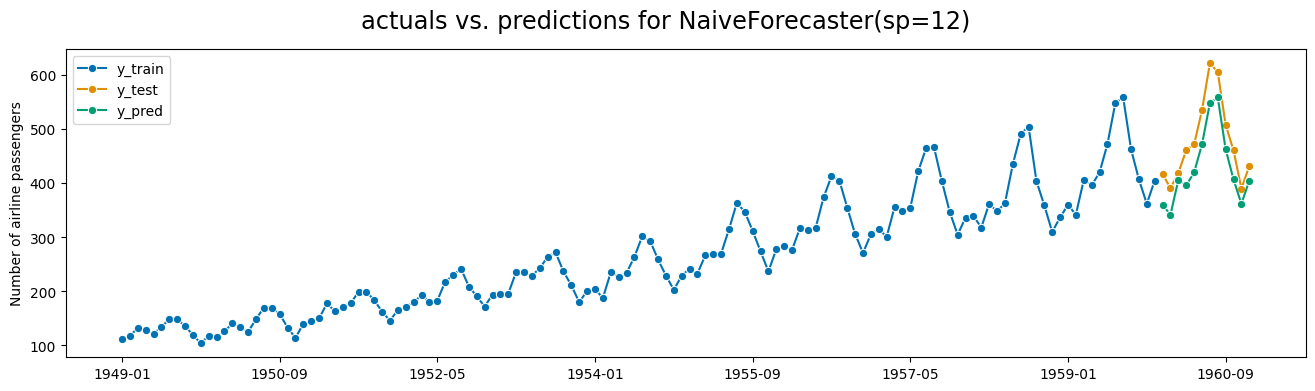

In [16]:
from sktime.utils.plotting import plot_series

title = f"actuals vs. predictions for {forecaster}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

In [17]:
# 2. specify the metric
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape_loss = MeanAbsolutePercentageError(symmetric=True)

In [18]:
# 3. evaluate the metric 
smape_loss(y_test, y_pred)

0.105718082574979

important note: this single number should not be used as a point of comparison, in general it is high variance!

better practice: backtesting experiment with sliding window, and optimally statistical hypothesis test

that's what `evaluate` and `benchmarking` are for (below)

side note: the `performance_metrics` module also contains "loose functions" for `sklearn` compatibility where needed, e.g., `mean_absolute_percentage_error`

BUT we encourage the use of classes, because:

* metric classes are first-class citizens in `sktime`, so
* visible to `all_estimators` search
* compatible with serialization workflows via `craft` or `save` (reproducibility!)
* visible as parameter tunable components in estimators, e.g., grid search tuning

to find metrics, use `all_estimators` with `"metric"` scitype for search:

(or look in the online API reference)

In [19]:
from sktime.registry import all_estimators

all_estimators("metric", as_dataframe=True)

,name,object
0,CRPS,<class 'sktime.performance_metrics.forecasting...
1,ConstraintViolation,<class 'sktime.performance_metrics.forecasting...
2,EmpiricalCoverage,<class 'sktime.performance_metrics.forecasting...
3,GeometricMeanAbsoluteError,<class 'sktime.performance_metrics.forecasting...
4,GeometricMeanRelativeAbsoluteError,<class 'sktime.performance_metrics.forecasting...
5,GeometricMeanRelativeSquaredError,<class 'sktime.performance_metrics.forecasting...
6,GeometricMeanSquaredError,<class 'sktime.performance_metrics.forecasting...
7,LogLoss,<class 'sktime.performance_metrics.forecasting...
8,MeanAbsoluteError,<class 'sktime.performance_metrics.forecasting...
9,MeanAbsolutePercentageError,<class 'sktime.performance_metrics.forecasting...


### 5.2.2 Metrics for point forecasts - advanced interface

metrics classes have a number of advanced features:

* automatic broadcasting to multivariate and hierarchical data
* automatic coercion of any `sktime` compatible data formats
* control of averaging over variables, time points, or multiple instances

let's get some multivariate predictions:

In [20]:
# 1. get actuals and predictions
from sktime.datasets import load_longley
from sktime.forecasting.naive import NaiveForecaster

_, y = load_longley()

y_train = y.iloc[:-3]
y_test = y.iloc[-3:]  # actuals
fh = [1, 2, 3]

forecaster = NaiveForecaster(strategy="last")

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()  # predictions

In [21]:
# 2. specify the metric
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape_loss = MeanAbsolutePercentageError(symmetric=True)

# 3. evaluate the metric
smape_loss(y_test, y_pred)

0.057968166987584516

... this also gives a number, by default:

* averages over time points in `y_pred` / `y_test` (rows)
* averages over variables (columns)

so, 3 rows and 5 columns:

In [22]:
y_pred

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1960,112.6,482704.0,3813.0,2552.0,123366.0
1961,112.6,482704.0,3813.0,2552.0,123366.0
1962,112.6,482704.0,3813.0,2552.0,123366.0


what if we don't want these averages?

variable (column) averaging is controlled by the `multioutput` arg.

`"raw_values"` prevents averaging, `"uniform_average"` computes arithmetic mean.

example without variable averaging:

In [23]:
# 2. specify the metric
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape_loss_by_var = MeanAbsolutePercentageError(symmetric=True, multioutput="raw_values")

# 3. evaluate the metric
smape_loss_by_var(y_test, y_pred)

array([0.02624645, 0.08347055, 0.10350425, 0.04168595, 0.03493363])

evaluation by row can be useful for diagnostics or statistical tests

for this, use the `evaluate_by_index` method:

In [24]:
smape_loss.evaluate_by_index(y_test, y_pred)
# entries are the variable-averaged smape loss for each index

Period
1960    0.023214
1961    0.074395
1962    0.076295
Freq: A-DEC, dtype: float64

In [25]:
smape_loss_by_var.evaluate_by_index(y_test, y_pred)
# entries are the variable-wise smape loss for each index

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1960,0.014109,0.040387,0.030475,0.015002,0.016098
1961,0.027157,0.070876,0.230421,0.007806,0.035714
1962,0.037473,0.139148,0.049616,0.102249,0.052989


Caveat: not every metric is an average over time points, e.g., RMSE

In this case, `evaluate_by_index` computes jackknife pseudo-samples

(for mean statistics, jackknife pseudo-samples are equal to individual samples)

let's look at hierarchical data & hierarchical level aggregation now:

In [26]:
# get some hierarchical data
from hierarchical_demo_utils import load_product_hierarchy

y = load_product_hierarchy()
y

Sales
Product line      Product group Date          
Food preparation  Hobs          2000-01  245.0
                                2000-02  144.0
                                2000-03  184.0
                                2000-04  265.0
                                2000-05  236.0
...                                        ...
Food preservation Fridges       2004-08  176.0
                                2004-09  205.0
                                2004-10   59.0
                                2004-11  151.0
                                2004-12  173.0

[240 rows x 1 columns]

In [27]:
# split y in train/test
# note that this is hierarchical,
# so we either do arcane pandas magic or use a splitter...
from sktime.forecasting.model_selection import ExpandingGreedySplitter

splitter = ExpandingGreedySplitter(3, folds=1)

y_train, y_test = next(splitter.split_series(y))

y_test

Sales
Product line      Product group Date          
Food preparation  Hobs          2004-10  157.0
                                2004-11  113.0
                                2004-12  119.0
                  Ovens         2004-10  139.0
                                2004-11  172.0
                                2004-12  178.0
Food preservation Freezers      2004-10  115.0
                                2004-11  121.0
                                2004-12  137.0
                  Fridges       2004-10   59.0
                                2004-11  151.0
                                2004-12  173.0

In [28]:
# get some predictions now
fh = [1, 2, 3]

forecaster = NaiveForecaster(strategy="last")

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()  # predictions

In [29]:
# 2. specify the metric
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape_loss = MeanAbsolutePercentageError(symmetric=True)

# 3. evaluate the metric
smape_loss(y_test, y_pred)

0.24986182525848374

this has aggregated over hierarchy levels, by arithmetic mean

hierarchy level (row index level) averaging is controlled by the `multilevel` arg.

`"raw_values"` prevents averaging, `"uniform_average"` computes arithmetic mean.

example without hierarchy averaging:

In [30]:
# 2. specify the metric
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError as MAPE

smape_loss_by_level = MAPE(symmetric=True, multilevel="raw_values")

# 3. evaluate the metric
smape_loss_by_level(y_test, y_pred)

MeanAbsolutePercentageError
Food preparation  Hobs                         0.177069
                  Ovens                        0.120988
Food preservation Freezers                     0.175142
                  Fridges                      0.526248

this can be combined with the other choices of averaging (or not):

In [31]:
smape_loss_by_level_and_variable = MAPE(
    symmetric=True, multilevel="raw_values", multioutput="raw_values"
)

smape_loss_by_level_and_variable.evaluate_by_index(y_test, y_pred)

Sales
Product line      Product group Date             
Food preparation  Hobs          2004-10  0.072607
                                2004-11  0.254826
                                2004-12  0.203774
                  Ovens         2004-10  0.273292
                                2004-11  0.061972
                                2004-12  0.027701
Food preservation Freezers      2004-10  0.100457
                                2004-11  0.151111
                                2004-12  0.273859
                  Fridges       2004-10  1.106061
                                2004-11  0.303371
                                2004-12  0.169312

### 5.2.3 Metrics for Probabilistic Forecasts

General usage pattern same as for point prediction metrics:

1. get some actuals and forecasts
2. specify the metric - similar to estimator specs
3. plug the actuals and forecasts into metric to get metric values

*but*: need to use dedicated metric for probabilistic forecasts

* i.e., match metric with type of forecast!

Recall methods available for all probabilistic forecasters:

- `predict_interval` produces interval forecasts.
  Argument `coverage` (nominal interval coverage) must be provided.
- `predict_quantiles` produces quantile forecasts.
  Argument `alpha` (quantile values) must be provided.
- `predict_var` produces variance forecasts. Same args as `predict`.
- `predict_proba` produces full distributional forecasts. Same args as `predict`.

| Name | param | prediction/estimate of | `sktime` |
| ---- | ----- | ---------------------- | -------- |
| point forecast | | conditional expectation $\mathbb{E}[y'\|y]$ | `predict` |
| variance forecast | | conditional variance $Var[y'\|y]$ | `predict_var` |
| quantile forecast | $\alpha\in (0,1)$ | $\alpha$-quantile of $y'\|y$ | `predict_quantiles` |
| interval forecast | $c\in (0,1)$| $[a,b]$ s.t. $P(a\le y' \le b\| y) = c$ | `predict_interval` |
| distribution forecast | | the law/distribution of $y'\|y$ | `predict_proba` |

where $y'$ is the forecast (considered a random variable) and $y$ is the observed history

let's produce some probabilistic forecasts!

In [32]:
from sktime.datasets import load_shampoo_sales
from sktime.forecasting.ets import AutoETS

y = load_shampoo_sales()
y_train = y.iloc[:-4]
y_test = y.iloc[-4:]

forecaster = AutoETS(auto=True)
fh = [1, 2, 3, 4]

forecaster.fit(y_train, fh=fh)

# use any of the probabilistic methods, we have seen this
y_pred_int = forecaster.predict_interval(coverage=0.95)
y_pred_q = forecaster.predict_quantiles(alpha=[0.05, 0.95])
y_pred_proba = forecaster.predict_proba()

these now all have their own output format:

In [33]:
y_pred_int  # lower/upper intervals

Number of shampoo sales            
                           0.95            
                          lower       upper
1993-09              389.650236  630.743131
1993-10              409.429859  651.972595
1993-11              428.319020  674.092522
1993-12              446.003062  697.417568

In [34]:
y_pred_q  # quantiles

Number of shampoo sales            
                           0.05        0.95
1993-09              409.030916  611.362452
1993-10              428.927087  632.475368
1993-11              448.075958  654.335584
1993-12              466.213463  677.207167

In [35]:
y_pred_proba  # sktime/skpro BaseDistribution

Normal(columns=Index(['Number of shampoo sales'], dtype='object'),
       index=PeriodIndex(['1993-09', '1993-10', '1993-11', '1993-12'], dtype='period[M]'),
       mu=         Number of shampoo sales
1993-09               510.196684
1993-10               530.701227
1993-11               551.205771
1993-12               571.710315,
       sigma=         Number of shampoo sales
1993-09                61.504420
1993-10                61.874284
1993-11                62.698474
1993-12                64.137532)

we now need to apply a suitable metric, `metric(y_test, y_pred)`

IMPORTANT: sequence matters, `y_test` first; `y_pred` has very different type!

In [36]:
# 2. specify metric
# CRPS = continuous ranked probability score, for distribution predictions
from sktime.performance_metrics.forecasting.probabilistic import CRPS

crps = CRPS()

# 3. evaluate metric
crps(y_test, y_pred_proba)

59.28763218963754

for averaging, same syntax as for point prediction metrics:

* `multioutput` for averaging over variables or not, via `multioutput="raw_values"`
* `multilevel` for averaging over hierarchy levels or not
* `evaluate_by_index` to return the loss by time index value (raw or pseudo-values)

In [37]:
# no averaging over time points, variables
from sktime.performance_metrics.forecasting.probabilistic import CRPS

crps_no_avg = CRPS(multioutput="raw_values")

crps_no_avg.evaluate_by_index(y_test, y_pred_proba)

,Number of shampoo sales
1993-09,137.198896
1993-10,33.026107
1993-11,20.306795
1993-12,46.618731


there are a lot of metrics...

how do we find a metric that fits the prediction type?

answer: metrics are tagged

important tag: `scitype:y_pred`

* `"pred_proba"` - distributional, can applied to distributions, `predict_proba` output
* `"pred_quantiles"` - quantile forecast metric, can be applied to quantile predictions, interval predictions, distributional predictions
    * applicable to `predict_quantiles`, `predict_interval`, `predict_proba` outputs
* `"pred_interval"` - interval forecast metric, can be applied to interval predictions, distributional predictions
    * applicable to `predict_interval`, `predict_proba` outputs

In [38]:
crps.get_tags()

{'requires-y-train': False,
 'requires-y-pred-benchmark': False,
 'univariate-only': False,
 'lower_is_better': True,
 'inner_implements_multilevel': False,
 'reserved_params': ['multioutput', 'score_average'],
 'scitype:y_pred': 'pred_proba'}

listing metrics with the tag, filtering for probabilistic tags:

(let's try to find a quantile forecast metric!)

In [39]:
from sktime.registry import all_estimators

proba_tag_values = ["pred_proba", "pred_interval", "pred_quantiles"]
all_estimators(
    "metric",
    as_dataframe=True,
    filter_tags={"scitype:y_pred": proba_tag_values},
    return_tags="scitype:y_pred",
)

,name,object,scitype:y_pred
0,CRPS,<class 'sktime.performance_metrics.forecasting...,pred_proba
1,ConstraintViolation,<class 'sktime.performance_metrics.forecasting...,pred_interval
2,EmpiricalCoverage,<class 'sktime.performance_metrics.forecasting...,pred_interval
3,LogLoss,<class 'sktime.performance_metrics.forecasting...,pred_proba
4,PinballLoss,<class 'sktime.performance_metrics.forecasting...,pred_quantiles
5,SquaredDistrLoss,<class 'sktime.performance_metrics.forecasting...,pred_proba


`PinballLoss` is a quantile forecast metric:

In [40]:
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

pinball_loss = PinballLoss()

pinball_loss(y_test, y_pred_q)

13.974275714765097

### 5.2.4 Time series splitters

Tuning and evaluation uses data splitter schemas, e.g., expanding window splitter.

`sktime` encodes data splitting schemas as objects of `"splitter"` type. Examples:

- `SingleWindowSplitter`, single train-test-split
- `SlidingWindowSplitter`, sliding window train set, followed by test set
- `ExpandingWindowSplitter`, expanding window test set, followed by test set
- `ExpandingGreedySplitter`, slices test set off from the end, rest is test set

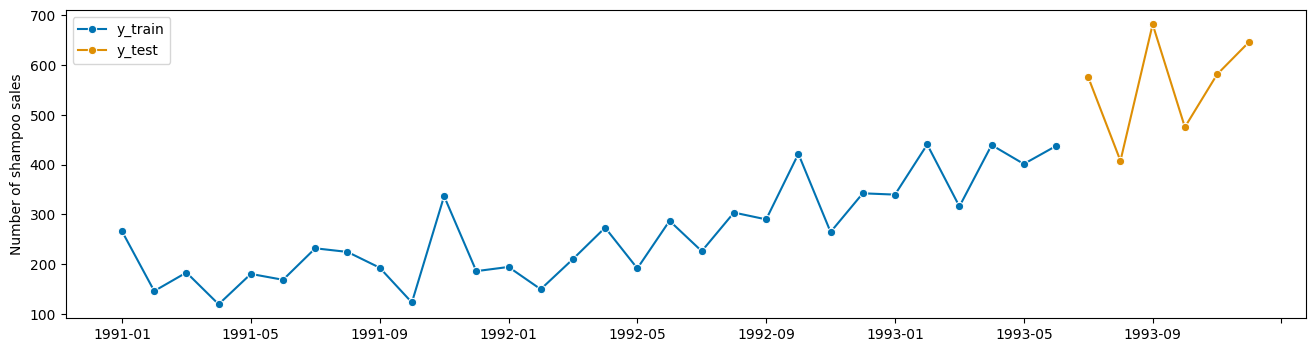

In [41]:
from sktime.datasets import load_shampoo_sales
from sktime.forecasting.model_selection import temporal_train_test_split

y = load_shampoo_sales()
y_train, y_test = temporal_train_test_split(y=y, test_size=6)
plot_series(y_train, y_test, labels=["y_train", "y_test"]);

In [42]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import (
    ExpandingGreedySplitter,
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
    SingleWindowSplitter,
)
from sktime.utils.plotting import plot_windows

fh = ForecastingHorizon(y_test.index, is_relative=False).to_relative(
    cutoff=y_train.index[-1]
)

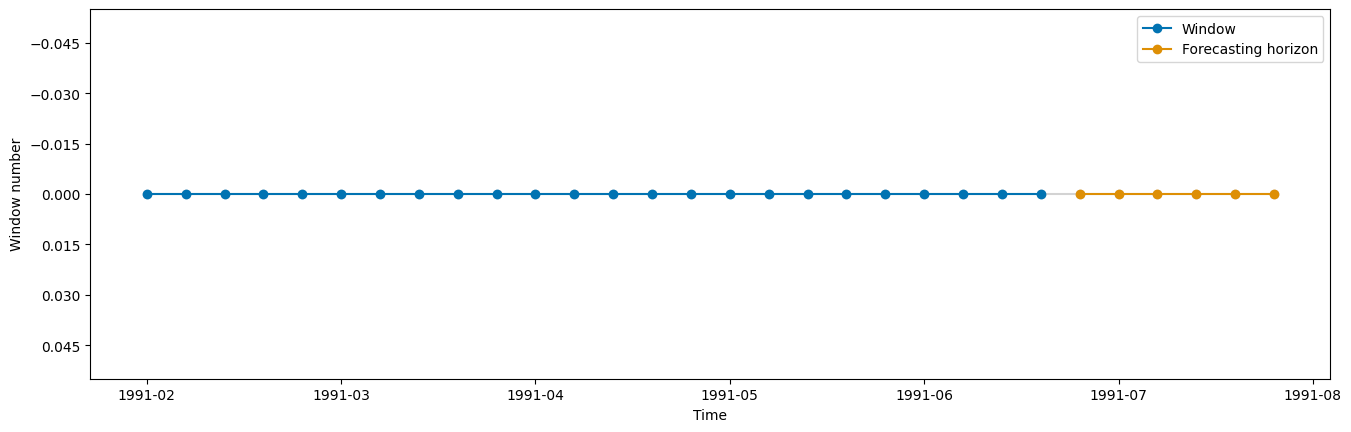

In [43]:
cv = SingleWindowSplitter(fh=fh, window_length=len(y_train) - 6)
plot_windows(cv=cv, y=y_train)

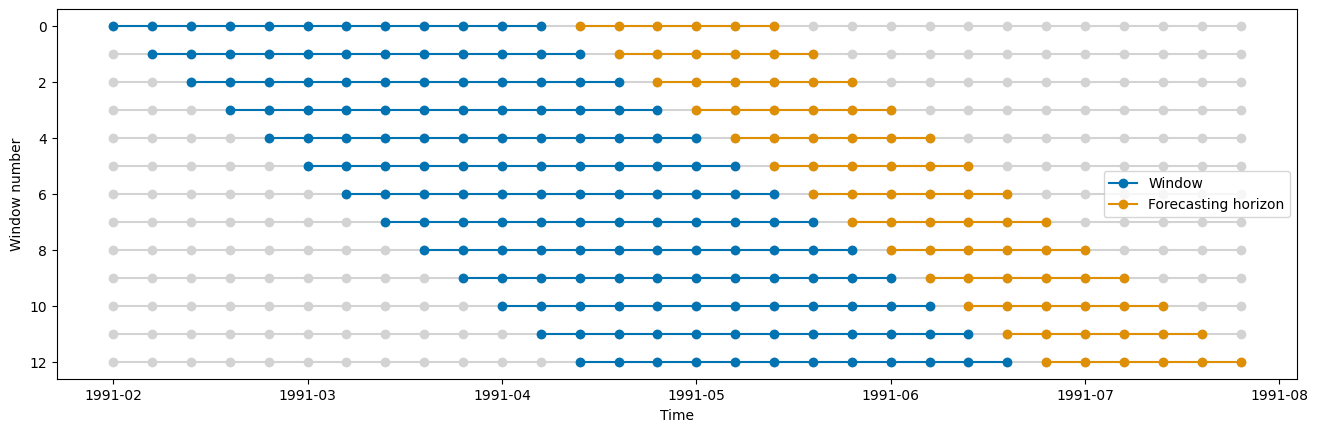

In [44]:
cv = SlidingWindowSplitter(fh=fh, window_length=12, step_length=1)
plot_windows(cv=cv, y=y_train)

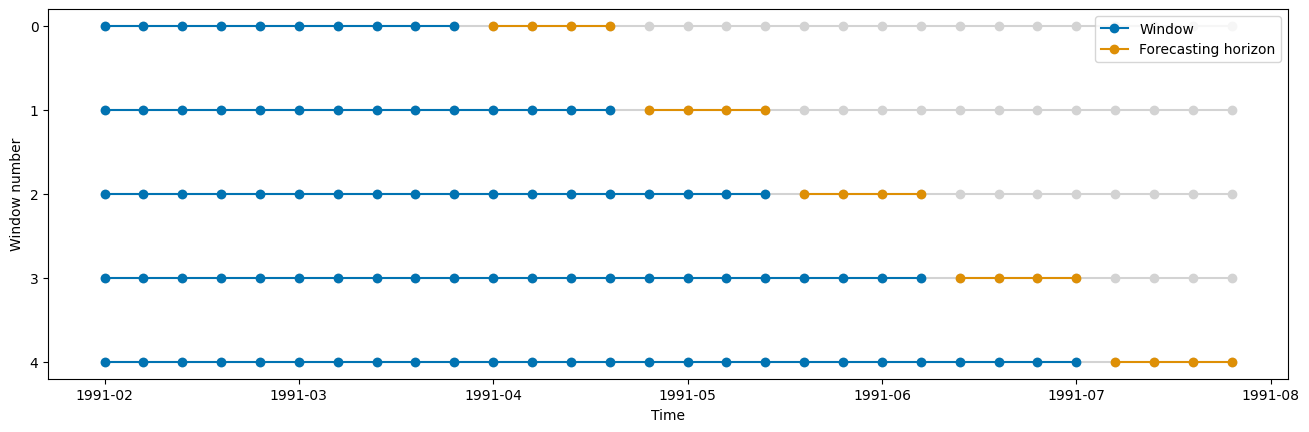

In [45]:
cv = ExpandingGreedySplitter(test_size=4)
plot_windows(cv=cv, y=y_train)

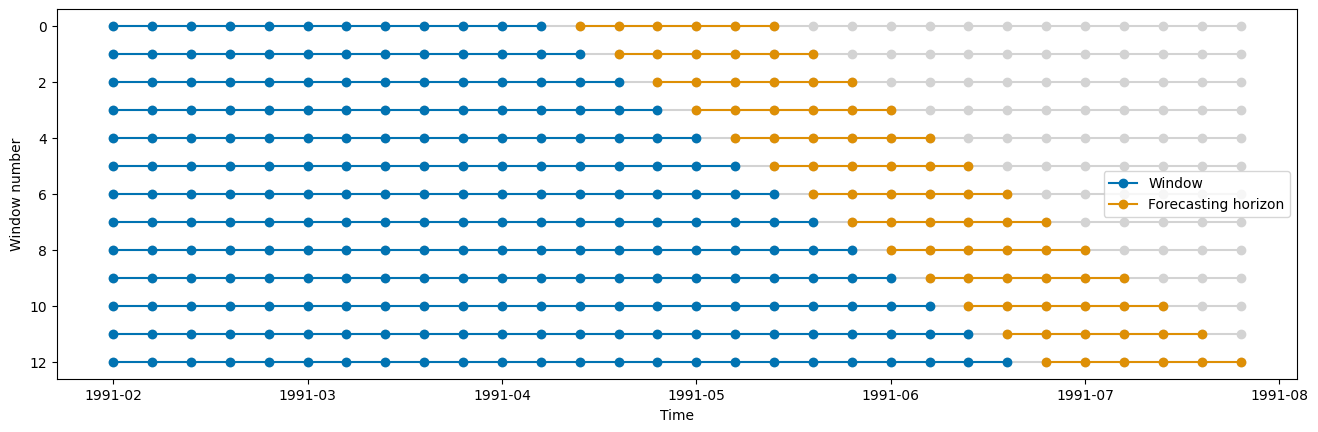

In [46]:
cv = ExpandingWindowSplitter(fh=fh, initial_window=12, step_length=1)
plot_windows(cv=cv, y=y_train)

In [47]:
# get number of total splits (folds)
cv.get_n_splits(y=y_train)

13

to list available splitters, use `all_estimators` with `"splitter"` type

In [48]:
from sktime.registry import all_estimators

all_estimators("splitter", as_dataframe=True)

,name,object
0,CutoffSplitter,<class 'sktime.forecasting.model_selection._sp...
1,ExpandingGreedySplitter,<class 'sktime.forecasting.model_selection._sp...
2,ExpandingWindowSplitter,<class 'sktime.forecasting.model_selection._sp...
3,SameLocSplitter,<class 'sktime.forecasting.model_selection._sp...
4,SingleWindowSplitter,<class 'sktime.forecasting.model_selection._sp...
5,SlidingWindowSplitter,<class 'sktime.forecasting.model_selection._sp...
6,TestPlusTrainSplitter,<class 'sktime.forecasting.model_selection._sp...


### 5.2.5 Simple evaluation and backtesting

Best practice for model evaluation: backtesting, sliding window

(not single split MAPE etc...)

how this works:

* define backtesting schema using cross-validation splitter
* simple workflows: use `evaluate` all-in-one evaluator
    * raw evaluates by backtest split, estimator, metric
* more advanced: use benchmarking module for experiments, next chapter!

data splitters (e.g., backtesting schemas) are first-class citizens in `sktime`

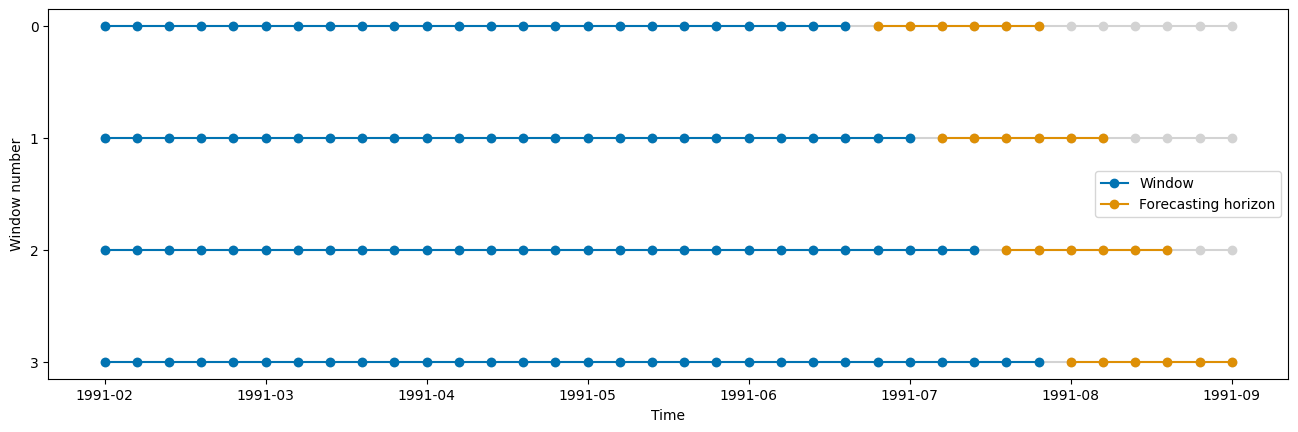

In [49]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.utils.plotting import plot_windows

cv = ExpandingWindowSplitter(initial_window=24, fh=fh, step_length=2)
n_folds = cv.get_n_splits(y)
plot_windows(cv, y)

Let's now run a simple evaluation loop:

In [50]:
# specify the data
from sktime.datasets import load_shampoo_sales

y = load_shampoo_sales()

In [51]:
# specify the estimator
from sklearn.ensemble import HistGradientBoostingRegressor
from sktime.forecasting.compose import make_reduction

regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=16)

In [52]:
# specify evaluation metric
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape_loss = MeanAbsolutePercentageError(symmetric=True)

In [53]:
from sktime.forecasting.model_evaluation import evaluate

forecaster = forecaster.clone()
scorers = smape_loss
backtest = evaluate(forecaster=forecaster, y=y, cv=cv, scoring=scorers)
backtest

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.282254,0.250374,0.021574,24,1992-12
1,0.298950,0.244031,0.026972,26,1993-02
2,0.396792,0.479918,0.023325,28,1993-04
3,0.477489,0.265965,0.024721,30,1993-06


result is a table with:

* rows = index of backtest splits from data splitter, here: expanding window split
* aggregated performance metric (over variables, instances, time points)
* runtimes for fit and predict
* cutoff = most recent time point seen in train in that split

`evaluate` can also:

* compute multiple metrics
* return data from individual splits

In [54]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanSquaredError

# another metric
rmse = MeanSquaredError(square_root=True)

forecaster = forecaster.clone()
scorers = [smape_loss, rmse]
backtest = evaluate(forecaster, y=y, cv=cv, scoring=scorers, return_data=True)
backtest

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred,test_MeanSquaredError
0,0.282254,0.247490,0.019745,24,1992-12,Period 1991-01 266.0 1991-02 145.9 1991-...,Period 1993-01 339.7 1993-02 440.4 1993-...,1993-01 234.800000 1993-02 272.200000 19...,104.903940
1,0.298950,0.243479,0.023854,26,1993-02,Period 1991-01 266.0 1991-02 145.9 1991-...,Period 1993-03 315.9 1993-04 439.3 1993-...,1993-03 259.58 1993-04 305.62 1993-05 ...,132.568132
2,0.396792,0.241734,0.020788,28,1993-04,Period 1991-01 266.0 1991-02 145.9 1991-...,Period 1993-05 401.3 1993-06 437.4 1993-...,1993-05 283.428571 1993-06 304.985714 19...,195.905290
3,0.477489,0.293742,0.026741,30,1993-06,Period 1991-01 266.0 1991-02 145.9 1991-...,Period 1993-07 575.5 1993-08 407.6 1993-...,1993-07 296.222222 1993-08 323.888889 19...,240.480380


## 5.3 Benchmarking - comparing estimator performance

the `benchmarking` module allows you to set up experiments to:

* compare the performance of one or more algorithms
* over one or multiple datasets
* against one or multiple performance metrics
* for a benchmark configuration defined by temporal resampling scheme


Benchmarking is very easy to get wrong...

see this [2022 research from Princeton](https://reproducible.cs.princeton.edu/)
for numerous examples of such mistakes in peer reviewed papers.

`sktime`'s `benchmarking` module is designed to:

* provide a high-level specification language
* prevent mistakes by abstracting away "dangerous" implementation details
* allow reproducible sharing of experiment setups and results

Any `sktime` compatible object can be plugged in!

* forecasters, transformers in pipelines, etc
* performance metrics
* cross-validation schemas
* datasets in `sktime` compatible formats

Use the `sktime` extension templates to add your favourite objects to the experiment!

advanced forecasting benchmark workflow, using `benchmark` module:

In [55]:
from sktime.benchmarking.forecasting import ForecastingBenchmark
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanSquaredPercentageError

### Instantiate an instance of a benchmark class
In this example we are comparing forecasting estimators.

In [56]:
benchmark = ForecastingBenchmark()

### Add competing estimators
We add different competing estimators to the benchmark instance. All added estimators will 
be automatically ran through each added benchmark tasks, and their results compiled.

In [57]:
benchmark.add_estimator(
    estimator=NaiveForecaster(strategy="mean", sp=12),
    estimator_id="NaiveForecaster-mean-v1",
)
benchmark.add_estimator(
    estimator=NaiveForecaster(strategy="last", sp=12),
    estimator_id="NaiveForecaster-last-v1",
)

### Add benchmarking tasks
These are the prediction/validation tasks over which every estimator will be tested and their results compiled.

The exact arguments for a benchmarking task depend on the whether the objective is forecasting, classification, etc.,
but generally they are similar. The following are the required arguments for defining a forecasting benchmark task.

#### Specify cross-validation split regime(s)
Define cross-validation split regimes, using standard `sktime` objects. 

In [58]:
cv_splitter = ExpandingWindowSplitter(
    initial_window=24,
    step_length=12,
    fh=12,
)

#### Specify performance metric(s)
Define performance metrics on which to compare estimators, using standard `sktime` objects.

In [59]:
scorers = [MeanSquaredPercentageError()]

#### Specify dataset loaders
Define dataset loaders, which are callables (functions) which should return a dataset. Generally
this is a callable which returns a dataframe containing the entire dataset. One can use
the `sktime` defined datasets, or define their own. Something as simple as the following
example will suffice: 
```python
def my_dataset_loader():
    return pd.read_csv("path/to/data.csv")
```
The datasets will be loaded when running the benchmarking tasks, ran through the cross-validation
regime(s) and subsequently the estimators will be tested over the dataset splits.

In [60]:
dataset_loaders = [load_airline]

#### Add tasks to the benchmark instance
Use the previously defined objects to add tasks to the benchmark instance.
Optionally use loops etc. to easily setup multiple benchmark tasks reusing arguments.

In [61]:
for dataset_loader in dataset_loaders:
    benchmark.add_task(
        dataset_loader,
        cv_splitter,
        scorers,
    )

### Run all task-estimator combinations and store results

Note that `run` won't rerun tasks it already has results for, so adding a new
estimator and running `run` again will only run tasks for that new estimator.

In [62]:
results_df = benchmark.run("./forecasting_results.csv")
results_df.T

,0,1
validation_id,[dataset=load_airline]_[cv_splitter=ExpandingW...,[dataset=load_airline]_[cv_splitter=ExpandingW...
model_id,NaiveForecaster-last-v1,NaiveForecaster-mean-v1
runtime_secs,0.531824,0.190186
MeanSquaredPercentageError_fold_0_test,0.024532,0.049681
MeanSquaredPercentageError_fold_1_test,0.020831,0.0737
MeanSquaredPercentageError_fold_2_test,0.001213,0.05352
MeanSquaredPercentageError_fold_3_test,0.01495,0.081063
MeanSquaredPercentageError_fold_4_test,0.031067,0.138163
MeanSquaredPercentageError_fold_5_test,0.008373,0.145125
MeanSquaredPercentageError_fold_6_test,0.007972,0.154337


### Credits: notebook 5 - Metrics and Evaluation

notebook creation: fkiraly, benheid